In [ ]:
import random
from tqdm import tqdm#진행률 바 형태로 출력

import torch
import torch.nn as nn
from torch.nn import functional as F#신경망 관련 함수 불러오는거
from torch.utils.data.sampler import SubsetRandomSampler#데이터셋에서 일부 샘플만 무작위로 추출해 사용할수 있게 해주는 샘플러

from torchsummary import summary#torch 모델의 구조와 파라미터 수 출력 도구
import torchvision.transforms as T#이미지 전처리
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE#고차원 데이터를 2차원 또는 3차원으로 시각화
from matplotlib import pyplot as plt
from IPython.display import display
from torchvision.transforms.functional import to_pil_image

In [ ]:
def make_fig(z, targets, epoch):#고차원 z를 2차원 데이터로 축소하고 클래스별로 색을 다르게 표시한 시각화 이미지 저장
    model = TSNE()#t-SNE 생성/ 차원 축소 기법. 데이터간의 유사성을 보존하면서 , 시각적으로 클러스터가 잘 보이도록 도와줌.
    transformed = model.fit_transform(z)#z를 t-SNE를 이용하여 2차원 데이터로 축소.

    plt.scatter(transformed[:, 0], transformed[:, 1], c=targets, alpha=.4, s=3**2)
    #transformed[:.0] -> 0번쨰 데이터만 들고오는것.
    #plt.scatter(x,y,점 색깔을 레이블에 따라 다르게, 점의 크기)
    #2차원 좌표로 산점도 그림
    plt.savefig(fname=f'{epoch}.png', format='png')#시각화 결과를 PNG 이미지 파일로 저장

### 학습된 모델이 데이터를 어떻게 구분했는지 확인할 때 유용

In [ ]:
LR = 0.0001
EPOCH = 200
BATCH_SIZE = 64
LATENT_DIM = 128
# 노이즈 벡터
# 내가 만들어 낼 이미지의 다양성과 복잡성
# 잠재 공간의 차원수
NUM_CLASSES = 10

In [ ]:
class SubsetSequentialSampler(torch.utils.data.Sampler):# 데이터셋에서 어떤 인덱스를 어떤 순서로 뽑을지 정의하는 클래스
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))# 인덱스를 하나씩 꺼낼수 있음

    def __len__(self):
        return len(self.indices)#샘플 개수

train = MNIST('./', train=True, download=True,
              transform=T.Compose([T.ToTensor(),
                                 T.Normalize((0.5,), (0.5,)),])
             )
# To.Tensor PIL또는 Numpy 이미지 torch.tensor로 변환/ pytorch는 tensor형태만 입력으로 받는다.
# train데이터에 normalize 추가하는 이유 : generater는 tanh을 사용(이미지 범위:-1~1)하여 가짜 이미지를 생성한다.
# gan은 진짜 이미지와 가짜이미지를 비교를 했을때 진짜인지 가짜인지 구분하기 힘들게 만들어야한다.
# 가짜 이미지와 진짜 이미지를 descriminator가 구분하게 힘들기 하기 위해선 각각의 이미지값 범위를 맞추면 구분하기 힘들거다.(범위가 다른거보다)
# 그래서 진짜 이미지값 범위도 -1~1로 하기 위해서 normalize를 해준다.
test = MNIST('./', train=False, download=True, transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.45MB/s]


In [ ]:
#  residual이랑 pooling을 하는 이유는 conditional을 할때 더 좋은 결과를 위해 하는거임.
class Residual(nn.Module):
    def __init__(self, channel):
        # 기울기 소실, 과적합, 본질 소실을 방지하기 위해서 입력을 그대로 다음에 넘겨줘서 정보 손실을 줄이고 학습을 안정화 시키는것
        # 딥하게 공부하게되면 본질을 잃고 중요한걸 놓칠수 있는데 중갅중간 다시 본질을 알려주는거지 .
        # residual 구조에서 원래 정보를 되살리고 보완하려고 쓰는거임. 정보가 잊히지 않게 상기시켜주는 역할임.
        super(Residual, self).__init__()

        self.conv1 = nn.Conv2d(channel, channel, kernel_size=3, stride=1, padding=1)
        # 이미지의 공간적 특징을 살리면서, 그안에서 특징을 추출하기 위해 사용
        # conv2는 선형구조임.
        # 이미지처럼 공간 구조가 중요한 데이터는 conv기반의 residual이 훨씬 효과적임.
        self.conv2 = nn.Conv2d(channel, channel, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channel)
        self.bn2 = nn.BatchNorm2d(channel)
        # GAN은 불안정해서 batchNorm2d로 정규화 해줘야한다.
        # generator랑 discriminator가 경쟁하면서 학습하기 때문에 빠르고 불안정하다.
        # batchnormal로 정규화 해주면서 값의 밸런스를 맞춰준다. (발산과 소멸을 막는다.)
        self.leaky = nn.LeakyReLU(inplace=False)
        # 입력 데이터를 잠재 벡터로 압축. 비선형이 필요해서 leakyrelu 사용
        # relu는 음수를 다 0으로 만들기 때문에, 뉴런이 완전히 죽을수 있다. 그래서 음수일때도 작은 기울기로 정보가 조금씩 흐를수있게 , 안정적으로 학습하게
        # 사용하는것......
        # inplace=False 이건 원본을 유지하고 새로 계산된 값 반환. True면 기존값 덮어씀.
        # True하면 원본값 날라가서 역전파에서 그 값을 기반으로 오차의 gradient 계산 못하니깐.

        # Linear는 전체적인 상호작용이 중요한 경우,
        # Conv2D는 공간적 구조나 지역 패턴이 중요한 경우에 더 적합하다.
        # 어떤 게 더 좋다고 단정짓긴 어렵고, 데이터 특성에 따라 다르게 선택해야 한다.

    def forward(self, x): #순전파 함수 정의
        out = self.leaky(self.bn1(self.conv1(x)))
        # Conv는 복잡하고 위치 기반의 특징을 추출하기 위해 사용되고,(conv는 선형이다.)
        # batchmormal로 정규화 해주면서 값의 밸런스를 맞춰준다
        # leakyrelu를 통해 비선형성을 부가해 더 복잡한 패턴을 학습할 수 있게 해준다.
        out = self.bn2(self.conv2(out))
        out = out + x
        # 변형된 정보에 원래 입력을 다시 더해주는 건
        # 학습 안정성과 본질 유지(정보 상기)를 위한 Residual의 핵심 원리이다.
        # 비선형을(leaky) 나중에 하는 이유는 residual을 한 뒤 비선형을 적용하는 이유는
        # 그래야 정보손실 없이 기억하면서 학습할 수 있기 때문이다.
        return self.leaky(out)

class Pooling(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Pooling, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1)
        # stride =2라서 풀링역할을 함.
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.leaky = nn.LeakyReLU(inplace=False)

    def forward(self, x):
        out_ = self.leaky(self.bn1(self.conv1(x)))
        return out_
        # VAE의 pooling층이 Gan보다 깊은 이유
        # VAE는 정확한 표현을 위해 깊고 복잡하게 특징을 뽑고,
        # GAN은 그럴듯한 결과를 빠르게 만들어내기 위해 가볍고 간단한 구조를 쓴다

# Residual은 "원래 의미를 유지"하고,
# Pooling은 "불필요한 건 줄이는 정리" 역할을 하니까,
# 둘이 함께 쓰면 정보는 잘 정제되면서도 본질은 지킬 수 있다!

In [ ]:
class Discriminator(nn.Module):# 판별자. 진짜인지 가짜인지 구별하는 역할
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block_1 = nn.Sequential(Residual(11), Pooling(11, 16))  # 14
        # Sequentil은 레이어 묶는 도구.
        # 11채널인 이유 : 이미지 1채널 + 레이블 10채널
        # 채널이란? 데이터가 가진 종류 다른 정보 조각.
        # 채널이 많아질수록 더 다양하고 복잡한 특징 표현 가능.
        # pooling(11,16)은 11채널을 풀링해서 16채널로 늘리는거야.  줄이면서 특징을 더 추출하는것. 다운샘플링하는 목적임.
        # mnist feature map size는 28*28이었고 block_1을 지나면 14*14로 변하는거임! -> pooling으로 데이터 정제
        self.block_2 = nn.Sequential(Residual(16), Pooling(16, 32))  # 7

        self.fc = nn.Linear(32, 1)
        # 입력 이미를 펼쳐서 1차원으로 줄임.완전연결층
        # 32개의 특징값을 1개로 바꾸기.
        self.GAP = nn.AdaptiveAvgPool2d(1)
        # GAP : Global Average Pooling / 각 채널별로 평균값 하나만 남김. 위치 정보가 필요 없어서(분류라서 위치 정보 안중요함.) 존재 강도(존재 여부)만 요약.
        # AdaptiveAgbPool2d = 한 채널당 딱 하나의 숫자(특징)만 남긴다.
        # 연산량이 확 줄고, 오버피팅이 준다. 결과는 항상 (c,1,1)로 뽑혀서 연산량이 작아짐. -> 모델이 작아짐.
        # 벡터형태로 요약되어 FC레이어에 넣기 좋다.
        # 장점: 파라미터가 줄어서 과적합 방지되고 ,학습이 잘 되고, 결과도 잘 나온다. 어떤 이미지 크기든 출력 벡터 크가 같아 입력 크기에 유연하다.
        self.leaky = nn.LeakyReLU(inplace=False)
        # 은닉층에서 주로 사용 , 비선형성 유지, 뉴런 죽음 방지
        self.sigmoid = nn.Sigmoid()
        # 출력층에서 주로 사용, 출력 결과를 확률처럼 쓰기위해 사용.
        # 모델 출력값을 0~1 사이로 정규화함.

    def forward(self, x, labels): # x:입력이미지, labels:이미지의 레이블
        ## 생성 조건 입력 방법으로 one-hot encoding 사용
        y = F.one_hot(labels, num_classes=NUM_CLASSES).reshape(labels.size(0), NUM_CLASSES, 1, 1)
        # (labels, num_classes=10) : y값을 10차원 벡터로 바꿈.
        # labels.size(0) : batch size임
        # 나중에 cat하기 위해서 바꿔주는 것.
        # y는 (64,10,1,1)이다. -> CNN에 넣기 좋게 채널 형태 바꿈.-> 공간 정보가 없음.
        y = y * torch.ones(x.size(0), NUM_CLASSES, x.size(2), x.size(3)).cuda()
        # pytorch에서 CNN 모델에 들어가는 이미지 데이터의 텐서 구조 (b(batch_size),c(channels),h(height),w(width))
        # batch_size : 한번에 처리하는 이미지의 개수, channels : 채널 수(흑백 1, 칼라 3, 또는 클래스 수), height : 이미지 세로 크기(픽셀수), width: 이미지 가로 크기
        # x.size()-> 0:batch_size, 1: channels(일반 이미지면 rgb값 3), 2: height, 3:width
        # 이미지와 레이블 정보를 채널 방향으로 결합

        ## y에 torch.ones(x)곱하는 이유는 공간 정보가 없어 공간 크기를 이미지와 맞추기 위해 곱하는것.그래야 cat 가능.
        # 서로 붙이려는 테서들의 크기가 반드시 맞아야함.
        x = torch.cat((x, y), dim=1)
        ##xy를 이어붙임. 왜냐면 cnn이 같이 처리할려고! 조건이랑 이미지 보여주면서 학습하란거지, 그래야 나중에 원하는 숫자 지정해서 생성할수있음.
        ## x= (64,1,28,28),y=(64,10,28,28) 둘이 cat하면 (64,11,28,28)
        # dim =1 : 채널방향으로 붙이는거임. 보통 cnn에서 조건 추가시 사용한다.
        # dim=10 배치방향 ,dim=2는 높이.dim3= 너비임.
        # cnn은 채널 특성을 뽑는데에 최적화돼 있고, 배치간 연결하면 구조가 깨지고, 너비나 높이로 연결하면 공간이 왜곡되기때문이다.
        # cat 하는 이유 : 조건과 이미지를 함꼐 고려해 학습을 하게 되니깐?

        out = self.block_1(x) # 다운 샘플링 28->14
        out = self.block_2(out) # 다운 샘플링 14 -> 7
        out = self.GAP(out) # 각 채널마다 평균갑 하나 남김
        out = out.view(out.size(0), -1) # 배치크기 유지한채로 flatten 시키기 FC에 넣기 위해서.
        out = self.fc(out) # 판별 결과값 출력 ( 진짜인지 가짜인지에 대한 점수 )
        return self.sigmoid(out) # 출력값 확률로 변환

## Discriminator 흐름
# 1. condition GAN이라 이미지와 라벨을 합쳐서 학습을 해야함.
# 2. 라벨 정보를 CNN에서 학습할 수 있는 채널 형태로 바꾸고 공간정보를 곱해줌.
# 3. 이미지와 2번을 거친 라벨을 cat 해줌.(이미지와 라벨 특징 같이 학습 시키기 위해)
# 4. residual,pooling을 통해 다운샘플링 * 2회 (이미지 크기 줄이기 및 특징 추출)
# 5. Adaptivepooling을 통해 다운 샘플링 ( 한 채널당 값 하나(특징 평균) 남김, 위치값 없애기) -> (64,32,1,1)
# 6. Flatten해서 벡터로 만듦. -> (64,32) / 32 : 32개의 특징
# 7. linear로 32->1 로 줄임. 최종 판별 점수 하나 뽑음  / 특징에 가중치 곱해서 하나의 점수 계산 (참 또는 거짓 이진분류이기 떄문에 진짜일 확률만 필요)
# 8. sigmoid를 이용해 확률로 표현

In [ ]:
class Transpose(nn.Module):# 업샘플링. generator(생성자)에서 사용
    ## generator는 이미지 생성을 하는데 작은 벡터를 받아서 늘려 이미지로 만든다.
    def __init__(self, in_channel, out_channel):
        super(Transpose, self).__init__()

        self.conv_trans = nn.ConvTranspose2d(in_channels=in_channel,
                                           out_channels=out_channel,
                                           kernel_size=4, stride=2, padding=1)
        # ConvTranspose2d : 전치 합성곱(이미지 크기를 2배 키움)

        self.conv1 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(out_channel)#gan은 불안정하니 사용. 정규화(발산,소멸 막음)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.leaky = nn.LeakyReLU(inplace=False)

    def forward(self, x):
        out_ = self.leaky(self.bn1(self.conv_trans(x)))
        # 업샘플링(이미지 크기 2배로 늘리기) -> 정규화(학습 안정화) -> 비선형성 추가,죽은 뉴런 방지
        out = self.bn2(self.conv1(out_))
        # 특징추출(업샘플된 feature 보정,특징 다듬기) -> 정규화
        out = out + out_
        # residual 연결 (정보 손실 최소화, 학습 안정화)
        return out
## transpose
# 크기를 늘리면서 특징을 잘 유지하고 학습을 안정화.
# generator 나 decoder 구조에 자주 사용

class Generator(nn.Module):# 생성자.
    def __init__(self):
        super(Generator, self).__init__()

        self.fc = nn.Linear(LATENT_DIM + NUM_CLASSES, 7*7*32)
        # 입력으로 노이즈와 레이블 정보를 받음(conditional GAN이라 레이블정보 받은거임.)
        self.bn = nn.BatchNorm1d(7*7*32)

        self.transpose_1 = Transpose(32, 16) #업샘플링
        self.transpose_2 = Transpose(16, 1) #업샘플링 -> 마지막 1채널 : 흑백이미지

        self.leaky = nn.LeakyReLU(inplace=False)
        self.tanh = nn.Tanh()
        # GAN의 Generator는 Than으로 비선형 함수 출력 조정함. 이미지는 픽셀값 범위가 정해져있어서.
        # MNIST처럼 흑백 이미지는 보통 픽셀값이 0~255
        # 신경망에서는 학습 안정성을 위해 입력 이미지를 -1~1로 정규화해서 학습한다.
        # Generator도 출력 결과를 -1~1 범위로 맞춰줌.
        # sigmoid를 안쓰는 이유는 0~1만 출력해서 흑백이미지에 부적합하다.
        # tanh을 붙여야 이미지가 실제 이미지처럼 보이고 학습도 안정적여진다.(폭주,발산이 줄어든다.)

    def forward(self, z, labels):#가짜이미지 생성
        # 레이블을 one-hot encoding하고 노이즈와 결합
        y = F.one_hot(labels, num_classes=NUM_CLASSES).float()
        # 신경망 입력에 맞게 float32로 변환
        # generator는 (노이즈+조건)을 받아서 이미지 만들어낸다.
        # 그래서 discriminator와 다르게 float형으로 변환한다.
        # discriminator은 이미지를 보고 판단하는거라 CNN이 학습 할수 있는 형식으로 변환하는거임.
        z = torch.cat([z, y], dim=1)
        # 노이즈와 조건을 합침.

        out = self.leaky(self.bn(self.fc(z)))
        out = out.view(out.size(0), 32, 7, 7)
        # 업샘플링할 수 있는 이미지 형태로 변형

        out = self.leaky(self.transpose_1(out))
        # 비선형성은 표현력을 높여줌.
        out = self.transpose_2(out)
        # 마지막 층은 이미지 출력 범위로 조정하는게 목적이라 비선형성 추가하지 않음

        return self.tanh(out) # 실제 이미지처럼 보이기 위해 tanh으로 정규화

## Generator
# 1. 노이즈와 라벨을 one-hot 한 뒤 float()형으로 변환하여 결합
# 2. fc로 특징을 추출하고 정규화 한 뒤 비선형성을 추가
# 3. 업샘플링할 수 있는 이미지 형태로 변환
# 4. 업샘플링 + 비선형 추가
# 5. 업샘플링 ( 비선형 추가하지 않은 이유는 마지막 층이라서 )
# 6. tanh으로 정규화해서 -1~1 범위로 만든 뒤 이미지 출력

In [ ]:
disc = Discriminator().cuda() # .cuda() 는 gpu로 계산한다는 뜻/ 판별자
gen = Generator().cuda() # 생성자

g_optim = torch.optim.Adam(gen.parameters(), lr=2e-4)
d_optim = torch.optim.Adam(disc.parameters(), lr=5e-5)

criterion = nn.BCELoss().cuda()
# BCELoss : 2진분류 손실 함수
# GAN에서 Discriminator가 판단할때 사용해야해서.
# 진짜 가짜를 이진 분류할 때 사용하는 손실 함수

In [ ]:
def train_discriminator(criterion, optimizer, real_data, real_labels, fake_data, fake_labels):
    n = real_data.size(0) # real_data 배치사이즈
    optimizer.zero_grad() # 기울기 초기화 : 하지 않으면 이상한 방향으로 학습됨.

    # 진짜 데이터에 대한 판별
    prediction_real = disc(real_data, real_labels)
    # 진짜 이미지를 보고 진짜라고 맞히도록 학습
    loss_real = criterion(prediction_real, torch.ones(n, 1).cuda())
    # 진짜 이미지를 진짜라고 예측한 정도를 평가한 손실값
    # torch.ones(n, 1) : 정답이 진짜임을 의미 . 예측값이 1에 가까울수록 손실이 낮음
    # 예 : 진짜 이미지를 보고 진짜일 확률이 95%야 했는데 진짜 이미지였다 그러면 이 손실값은 5%이다.
    loss_real.backward()
    # 역전파 : 각 가중치가 손실에 얼마나 영향을 주었는지 계산해서 다음번 가중치 업데이트 방향 결정.
    # 손실값을 가지고 어떻게 가중치를 업데이트할지 결정한다.

    # 가짜 데이터에 대한 판별
    prediction_fake = disc(fake_data, fake_labels)
    # 가짜 이미지를 보고 가짜라고 맞히도록 학습
    loss_fake = criterion(prediction_fake, torch.zeros(n, 1).cuda())
    # torch.zeros(n, 1) : 정답이 가짜임을 의미 . 예측값이 0에 가까울수록 손실이 낮음
    # 가짜 이미지를 가짜라고 예측한 정도를 평가한 손실값
    loss_fake.backward()

    optimizer.step() # 역전파가 알려준 만큼 가중치 업데이트
    return loss_real + loss_fake # 손실값들을 더해서 generator가 잘 판단했는지 평가.

def train_generator(criterion, optimizer, fake_data, fake_labels):
    n = fake_data.size(0) # 가짜 이미의 배치사이즈
    optimizer.zero_grad()

    prediction = disc(fake_data, fake_labels)
    # 가짜 이미지를 보고 가짜라고 맞히도록 학습
    loss = criterion(prediction, torch.ones(n, 1).cuda())
    # generator은 손실 계산시 진짜처럼 보이게 하기 위해 진짜용 손실계산기로(torch.ones) 적용 .
    # 결국엔 저 손실값을 줄이기 위해 가중치 수정해가며 학습

    loss.backward()
    optimizer.step()
    return loss


Generating images for epoch 5...


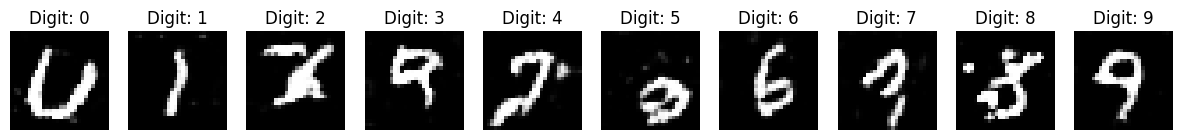

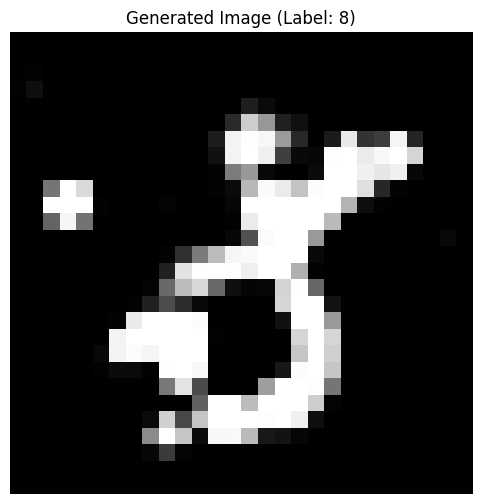

✓ Images saved: generated_images_epoch_5.png and comparison_epoch_5.png



Generating images for epoch 10...


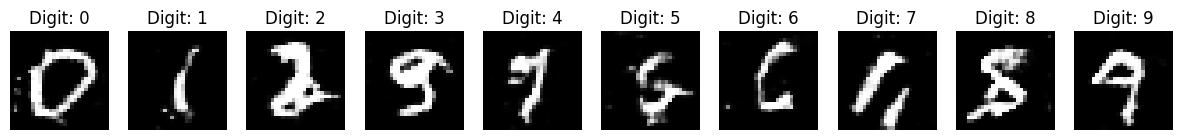

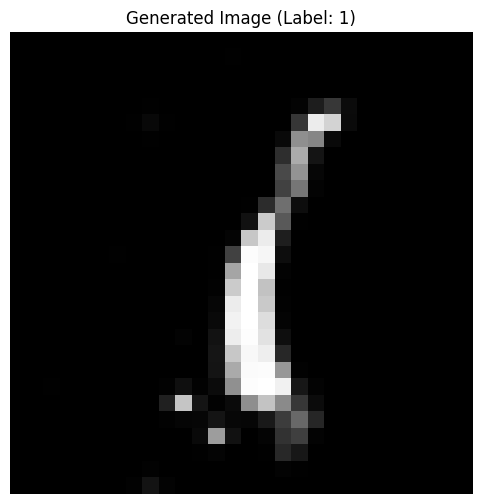

✓ Images saved: generated_images_epoch_10.png and comparison_epoch_10.png



Generating images for epoch 15...


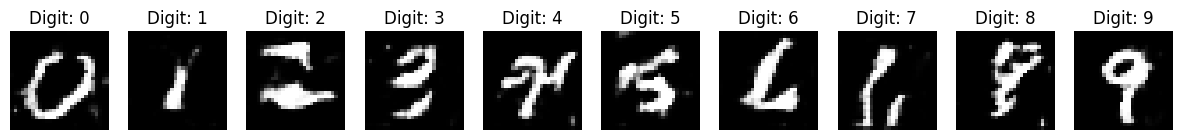

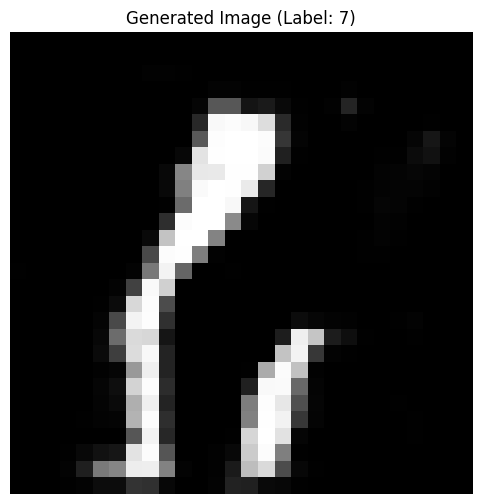

✓ Images saved: generated_images_epoch_15.png and comparison_epoch_15.png



Generating images for epoch 20...


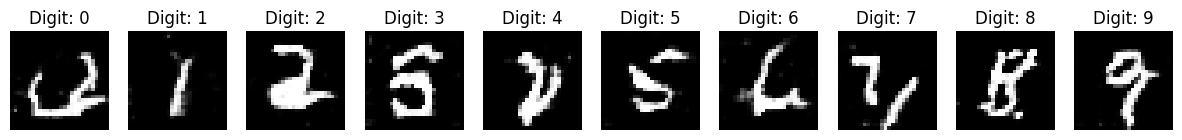

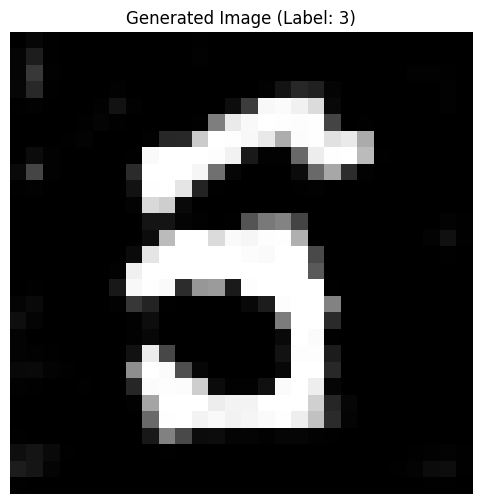

✓ Images saved: generated_images_epoch_20.png and comparison_epoch_20.png



Generating images for epoch 25...


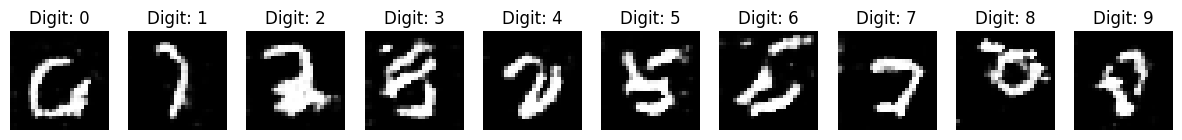

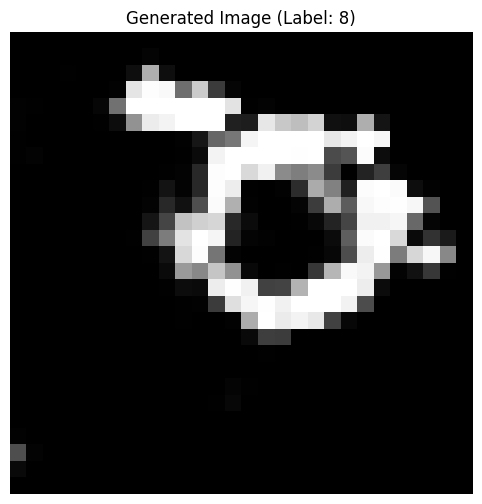

✓ Images saved: generated_images_epoch_25.png and comparison_epoch_25.png



Generating images for epoch 30...


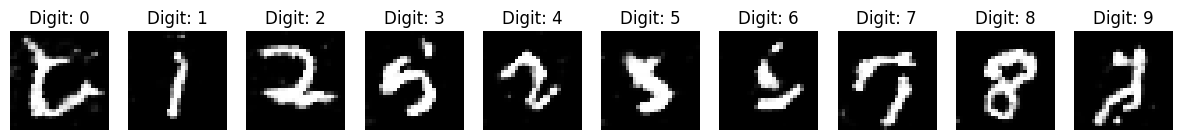

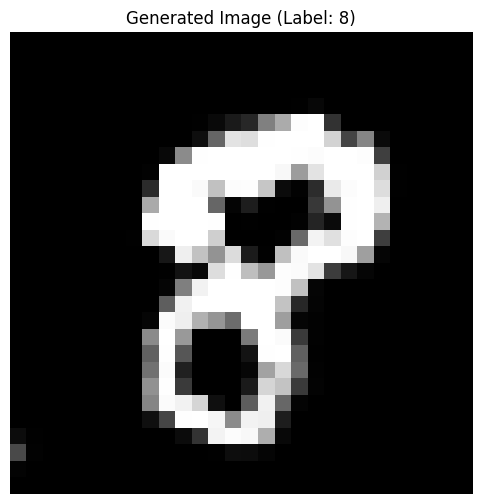

✓ Images saved: generated_images_epoch_30.png and comparison_epoch_30.png



Generating images for epoch 35...


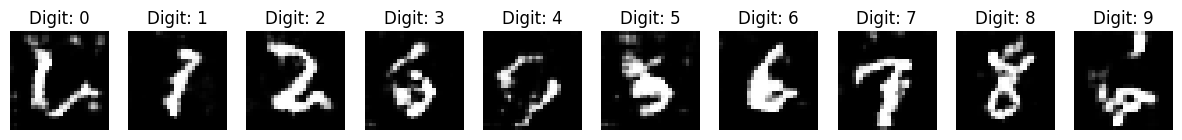

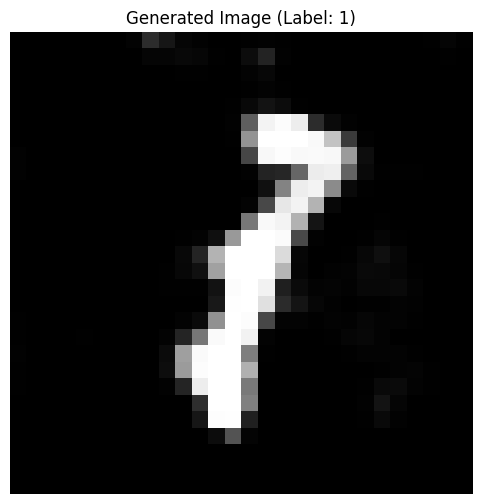

✓ Images saved: generated_images_epoch_35.png and comparison_epoch_35.png



Generating images for epoch 40...


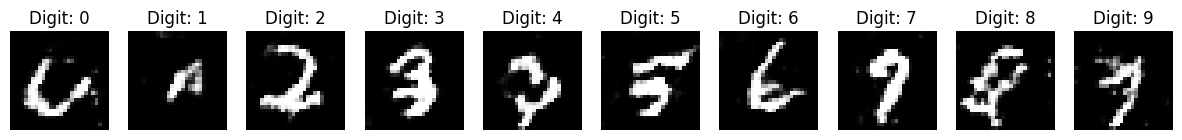

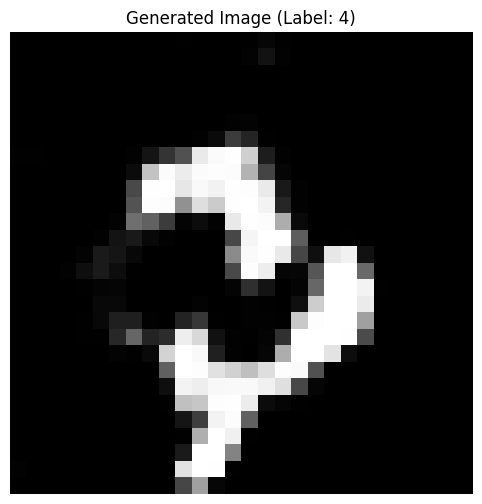

✓ Images saved: generated_images_epoch_40.png and comparison_epoch_40.png



Generating images for epoch 45...


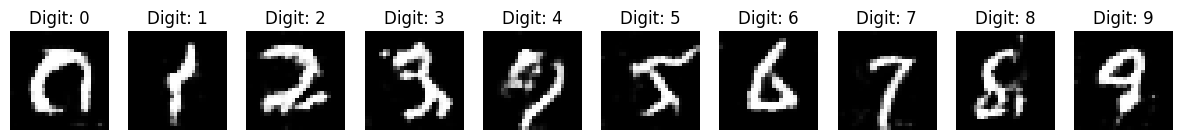

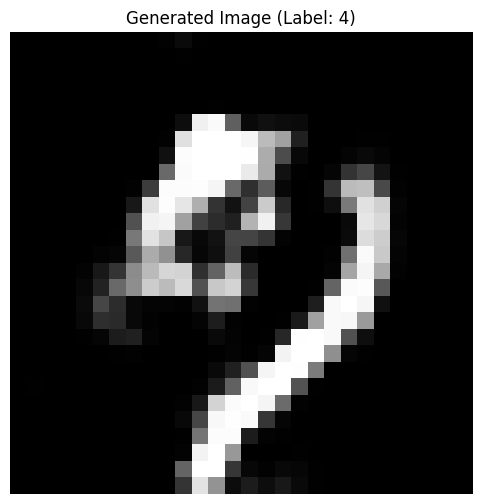

✓ Images saved: generated_images_epoch_45.png and comparison_epoch_45.png



Generating images for epoch 50...


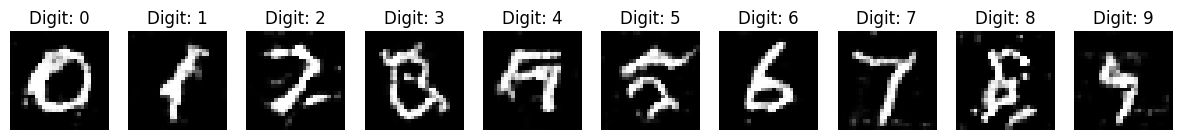

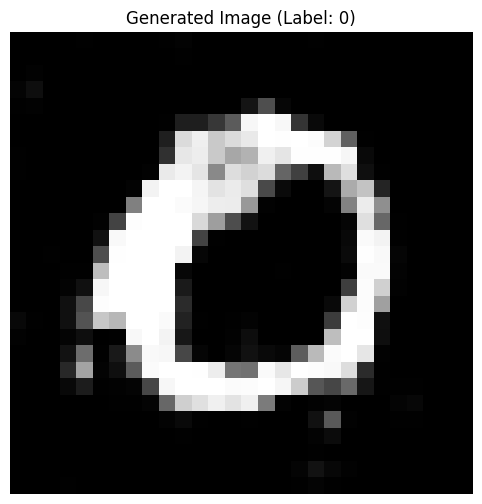

✓ Images saved: generated_images_epoch_50.png and comparison_epoch_50.png



Generating images for epoch 55...


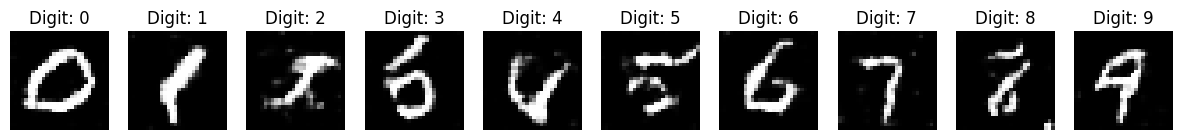

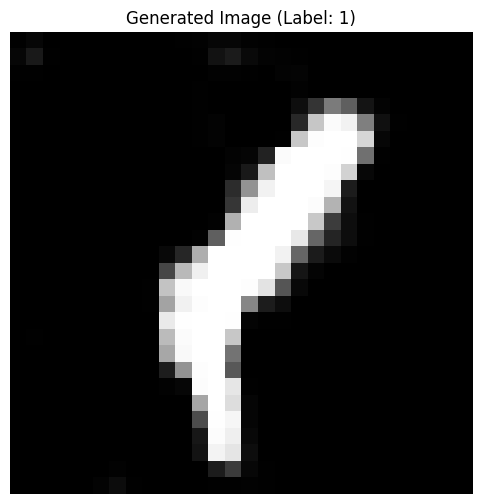

✓ Images saved: generated_images_epoch_55.png and comparison_epoch_55.png



Generating images for epoch 60...


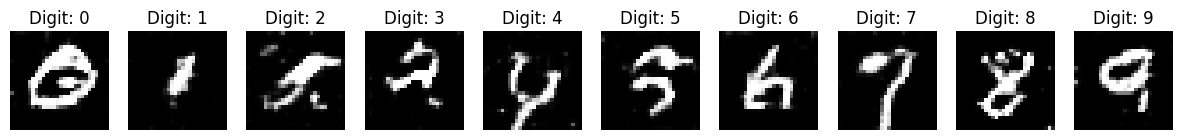

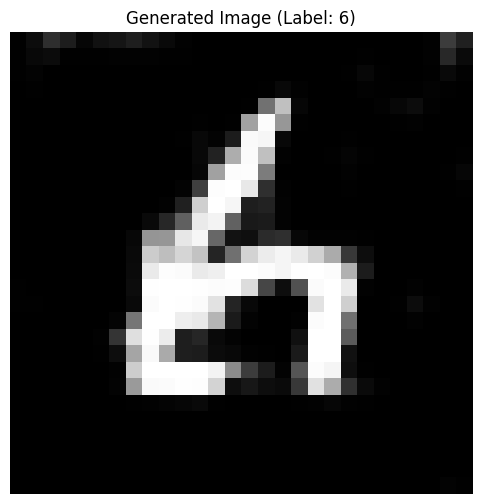

✓ Images saved: generated_images_epoch_60.png and comparison_epoch_60.png



Generating images for epoch 65...


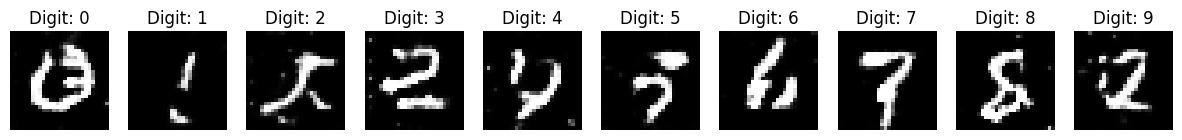

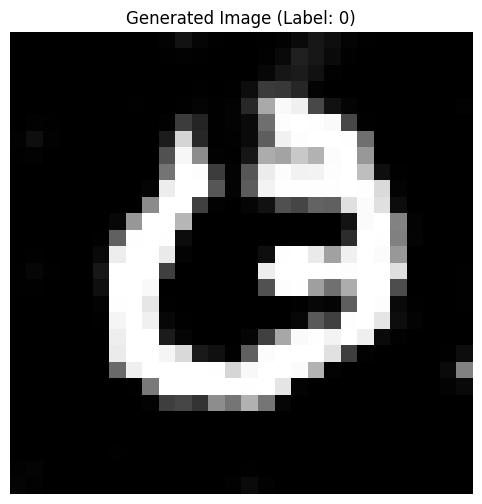

✓ Images saved: generated_images_epoch_65.png and comparison_epoch_65.png



Generating images for epoch 70...


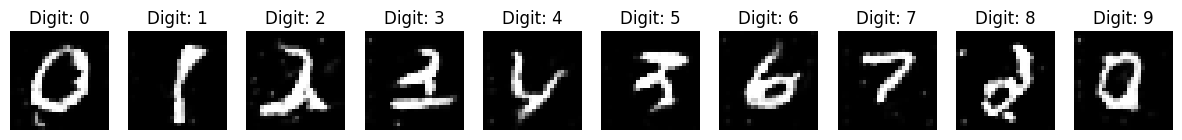

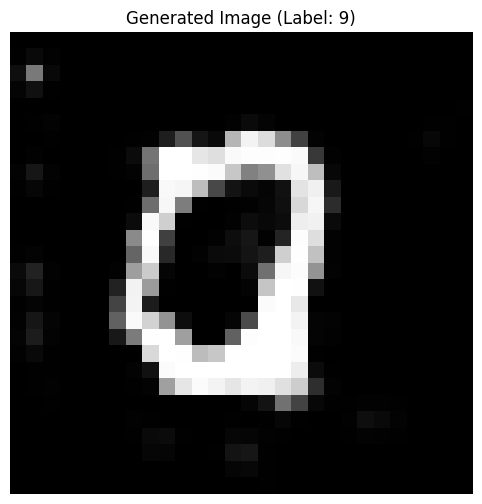

✓ Images saved: generated_images_epoch_70.png and comparison_epoch_70.png



Generating images for epoch 75...


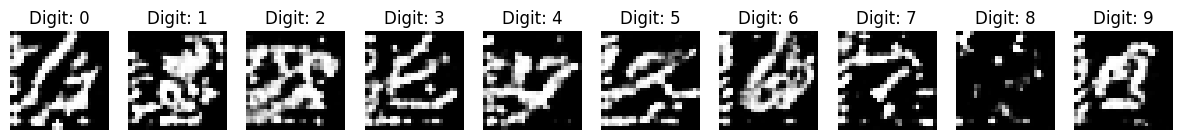

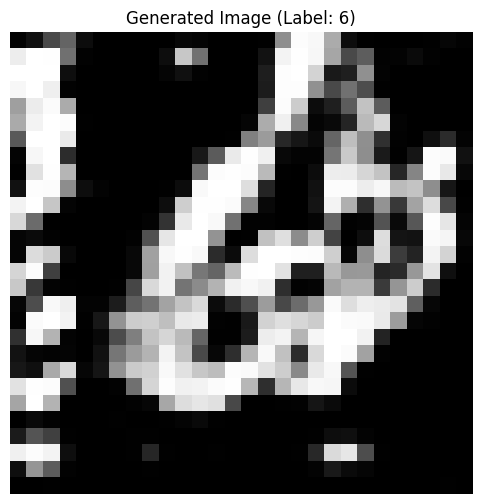

✓ Images saved: generated_images_epoch_75.png and comparison_epoch_75.png



Generating images for epoch 80...


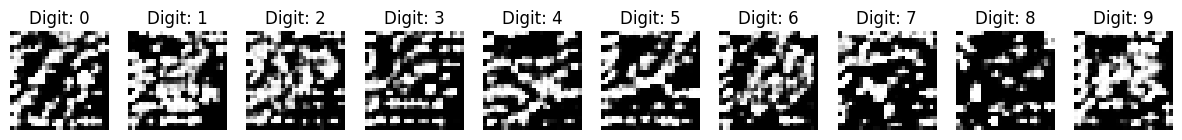

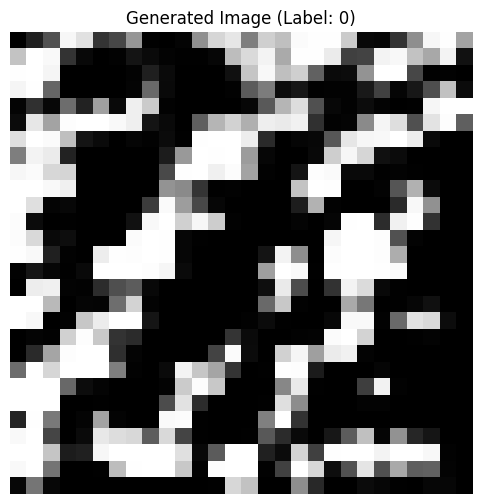

✓ Images saved: generated_images_epoch_80.png and comparison_epoch_80.png



Generating images for epoch 85...


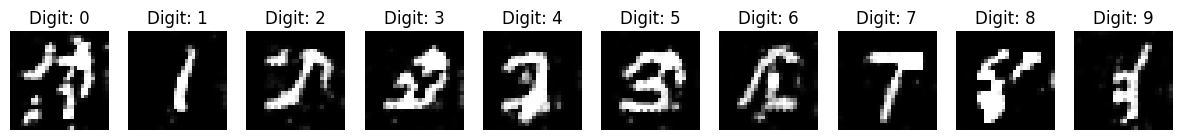

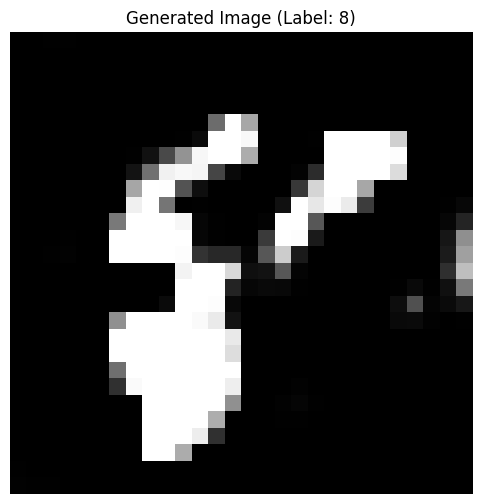

✓ Images saved: generated_images_epoch_85.png and comparison_epoch_85.png



Generating images for epoch 90...


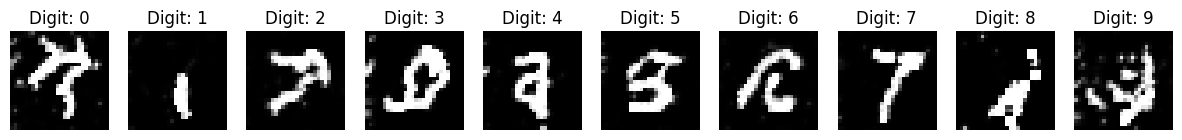

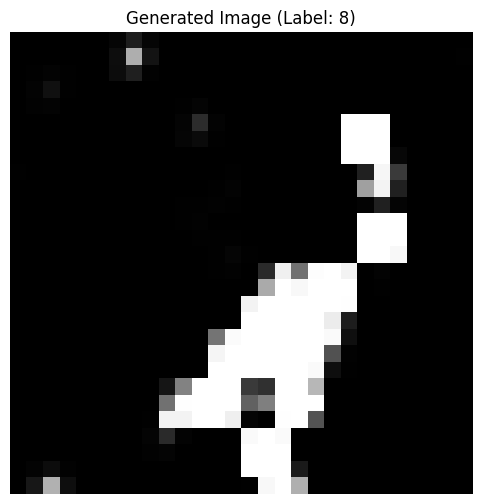

✓ Images saved: generated_images_epoch_90.png and comparison_epoch_90.png



Generating images for epoch 95...


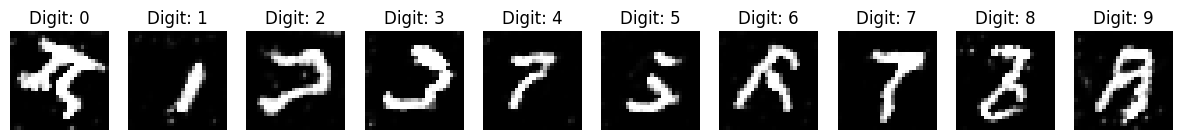

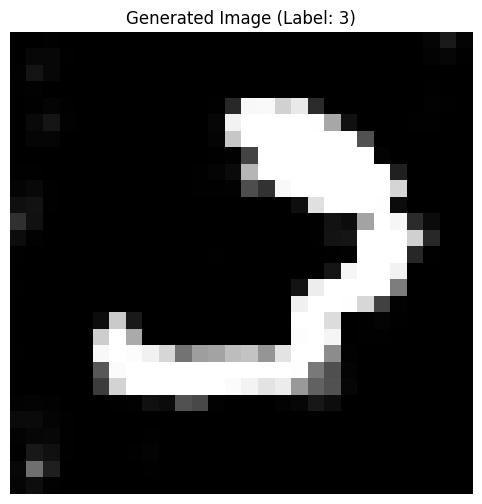

✓ Images saved: generated_images_epoch_95.png and comparison_epoch_95.png



Generating images for epoch 100...


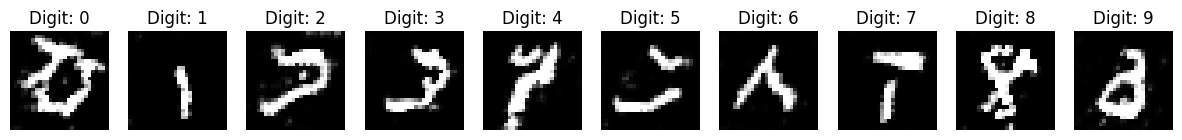

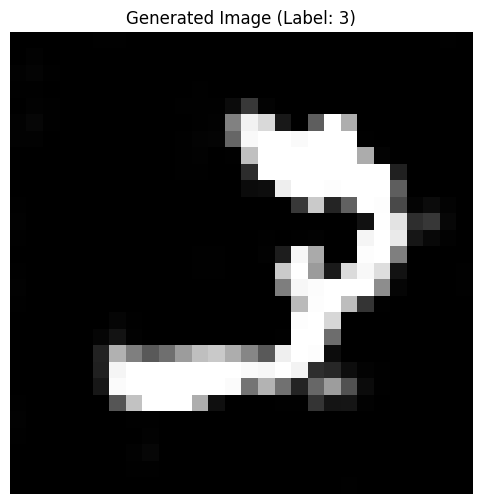

✓ Images saved: generated_images_epoch_100.png and comparison_epoch_100.png



Generating images for epoch 105...


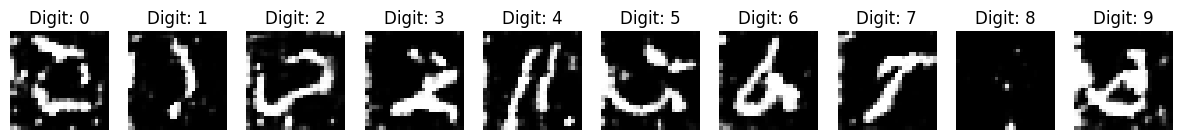

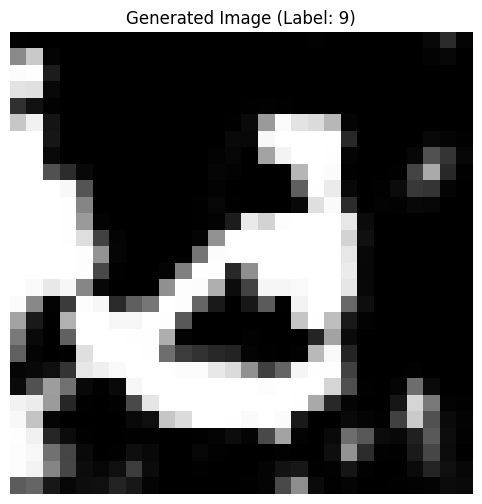

✓ Images saved: generated_images_epoch_105.png and comparison_epoch_105.png



Generating images for epoch 110...


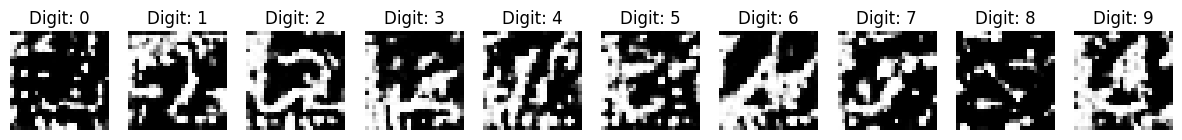

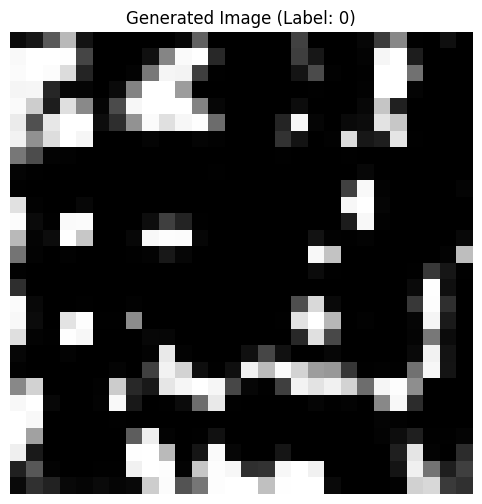

✓ Images saved: generated_images_epoch_110.png and comparison_epoch_110.png



Generating images for epoch 115...


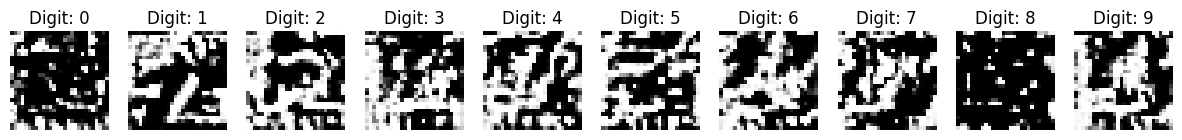

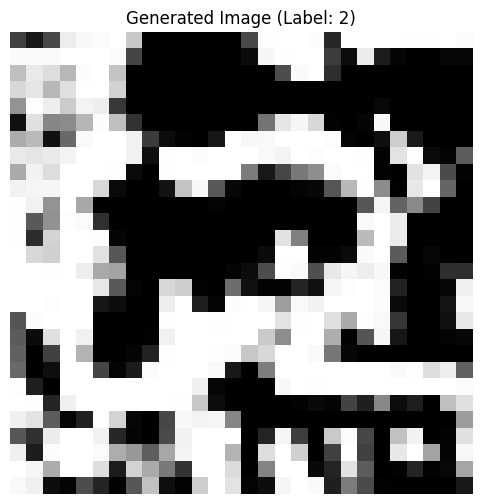

✓ Images saved: generated_images_epoch_115.png and comparison_epoch_115.png



Generating images for epoch 120...


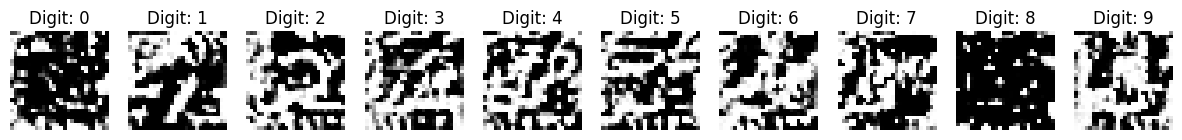

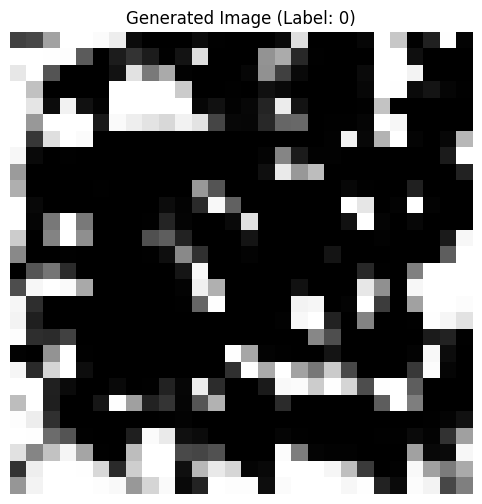

✓ Images saved: generated_images_epoch_120.png and comparison_epoch_120.png



Generating images for epoch 125...


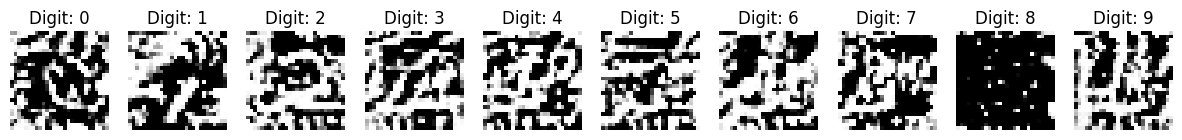

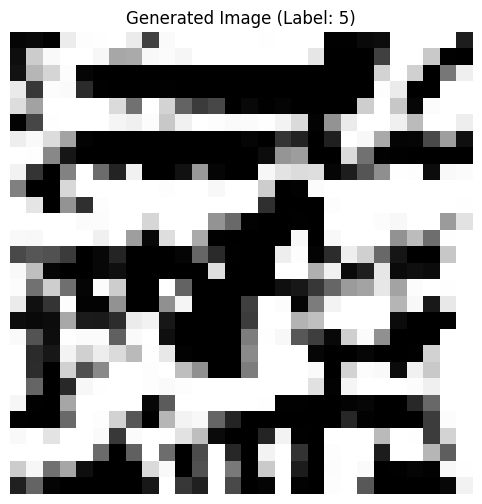

✓ Images saved: generated_images_epoch_125.png and comparison_epoch_125.png



Generating images for epoch 130...


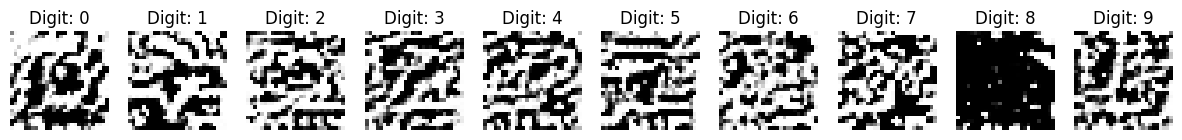

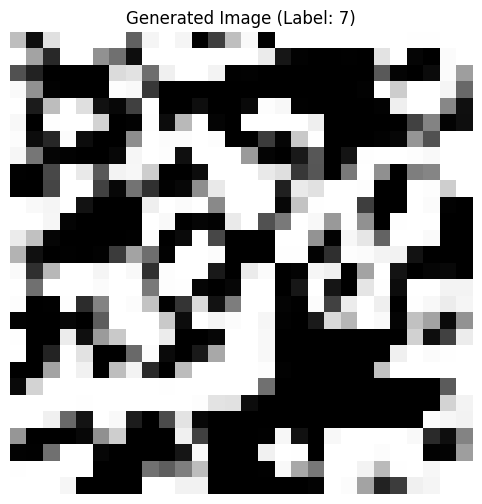

✓ Images saved: generated_images_epoch_130.png and comparison_epoch_130.png



Generating images for epoch 135...


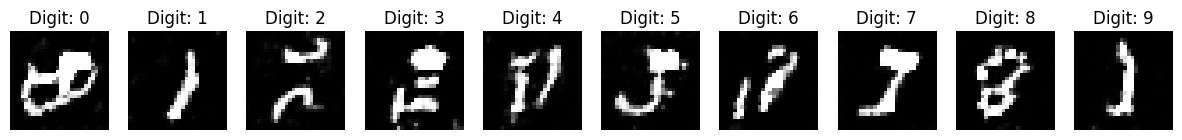

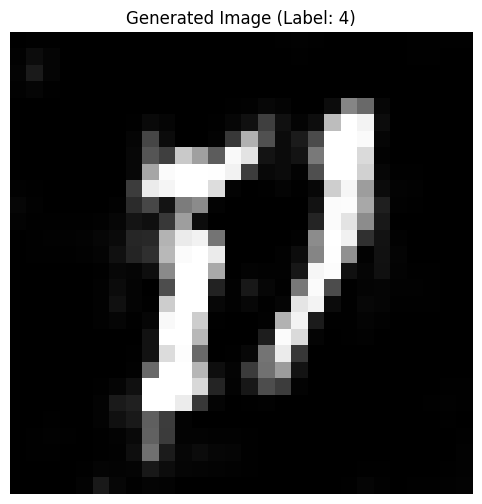

✓ Images saved: generated_images_epoch_135.png and comparison_epoch_135.png



Generating images for epoch 140...


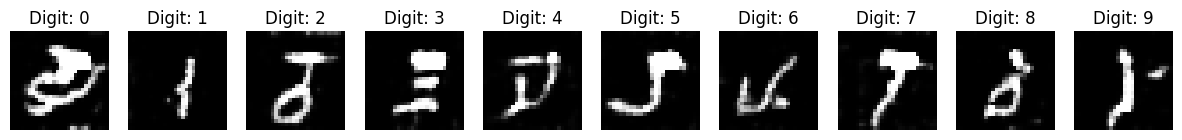

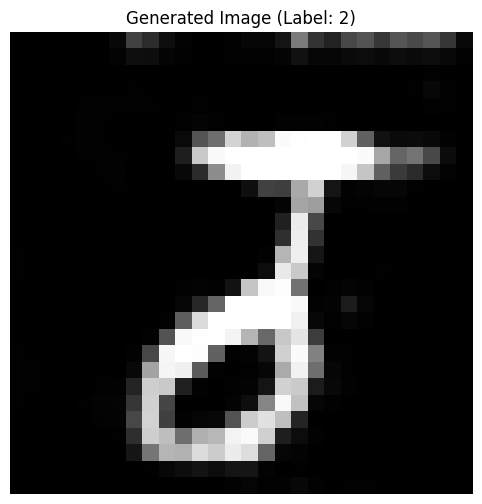

✓ Images saved: generated_images_epoch_140.png and comparison_epoch_140.png



Generating images for epoch 145...


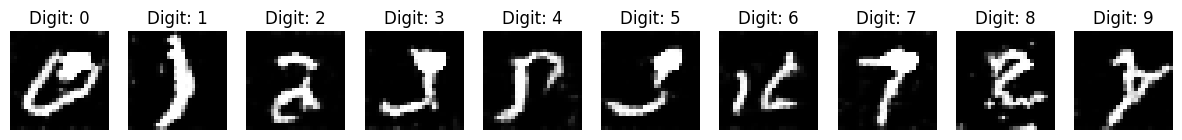

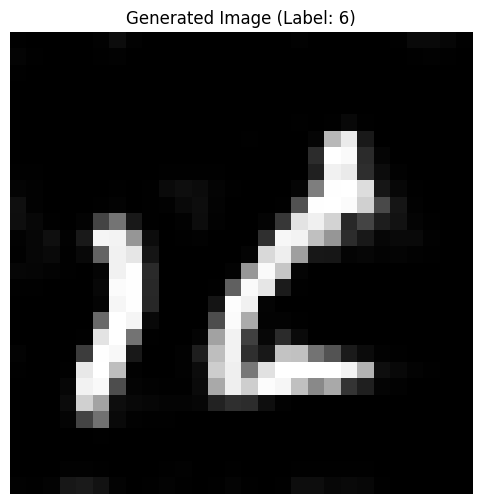

✓ Images saved: generated_images_epoch_145.png and comparison_epoch_145.png



Generating images for epoch 150...


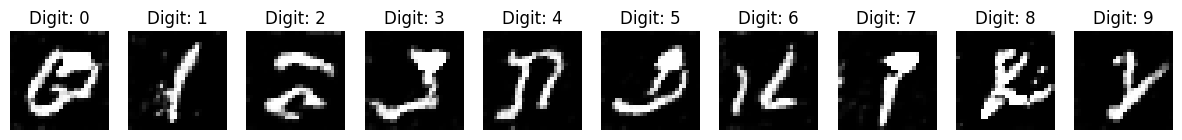

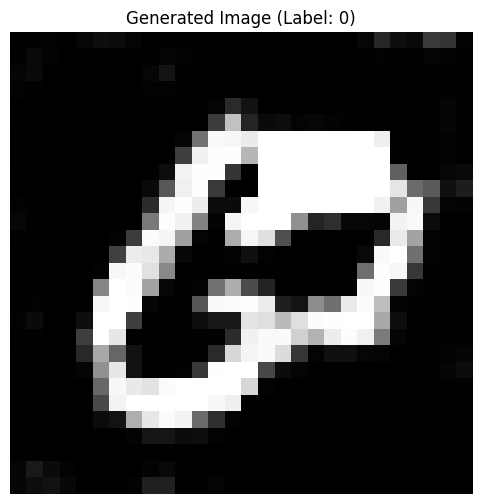

✓ Images saved: generated_images_epoch_150.png and comparison_epoch_150.png



Generating images for epoch 155...


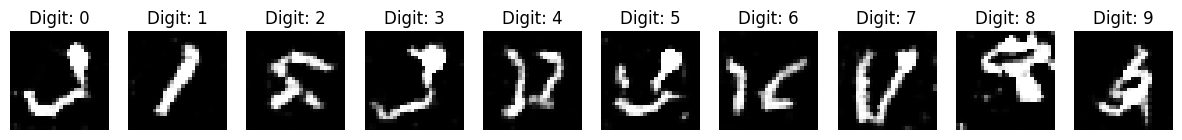

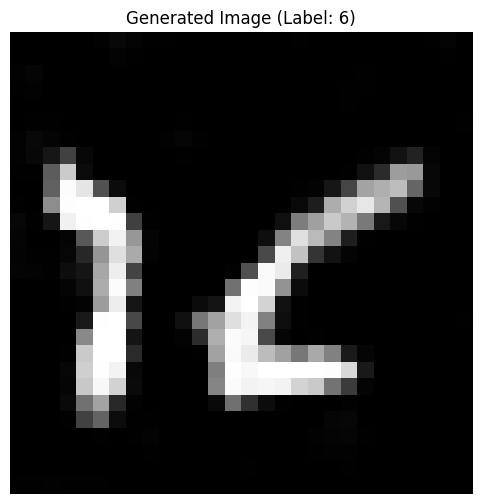

✓ Images saved: generated_images_epoch_155.png and comparison_epoch_155.png



Generating images for epoch 160...


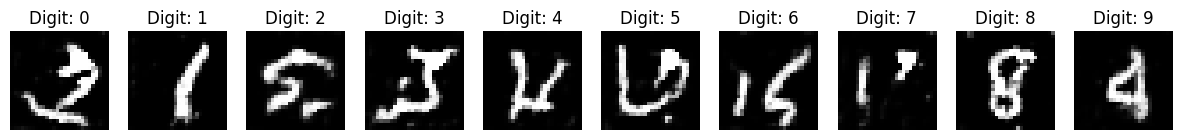

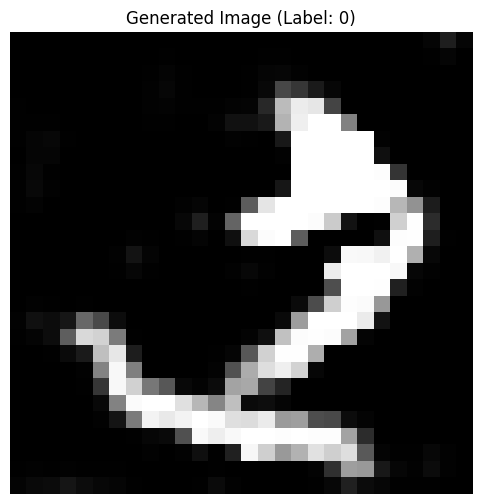

✓ Images saved: generated_images_epoch_160.png and comparison_epoch_160.png



Generating images for epoch 165...


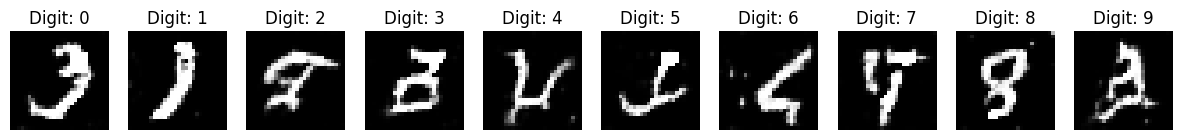

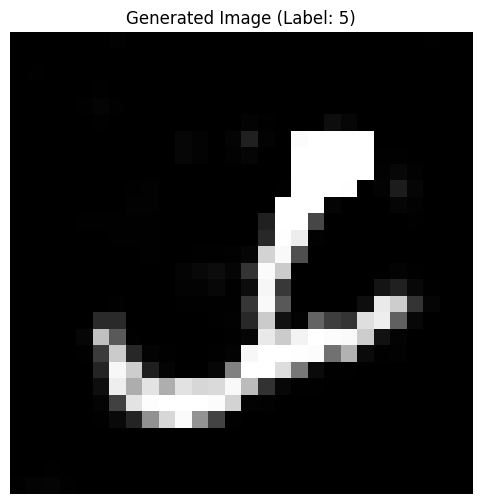

✓ Images saved: generated_images_epoch_165.png and comparison_epoch_165.png



Generating images for epoch 170...


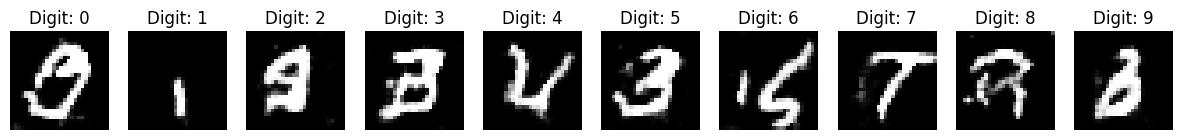

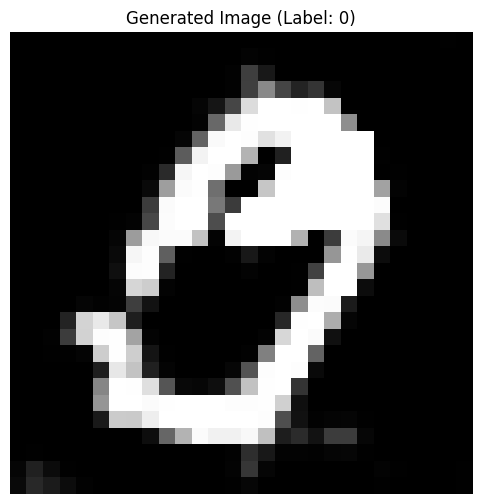

✓ Images saved: generated_images_epoch_170.png and comparison_epoch_170.png



Generating images for epoch 175...


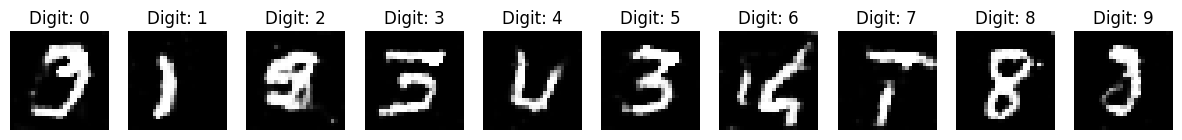

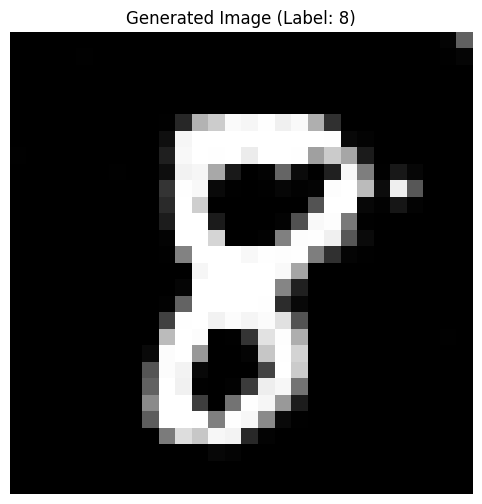

✓ Images saved: generated_images_epoch_175.png and comparison_epoch_175.png



Generating images for epoch 180...


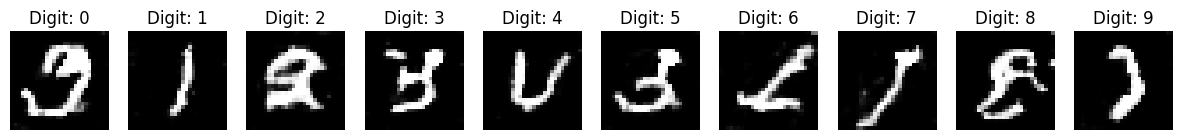

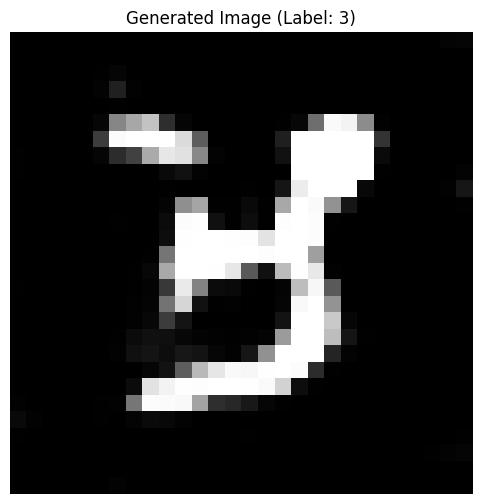

✓ Images saved: generated_images_epoch_180.png and comparison_epoch_180.png



Generating images for epoch 185...


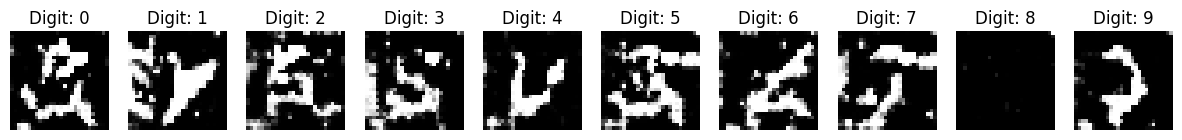

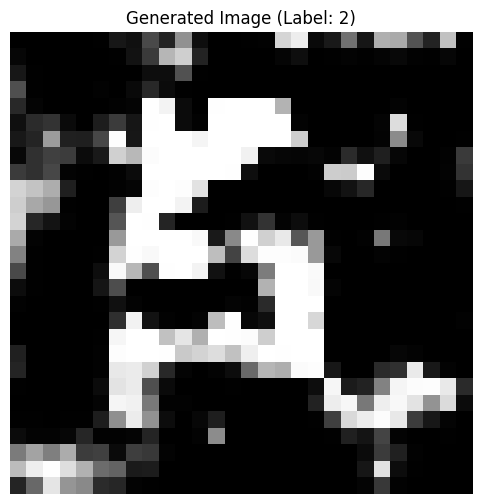

✓ Images saved: generated_images_epoch_185.png and comparison_epoch_185.png



Generating images for epoch 190...


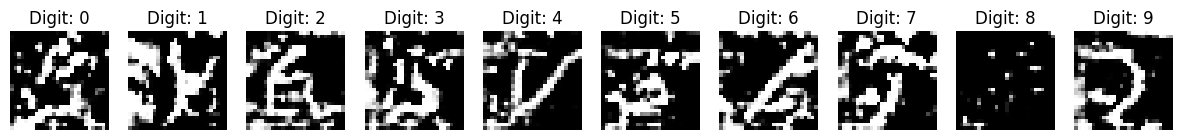

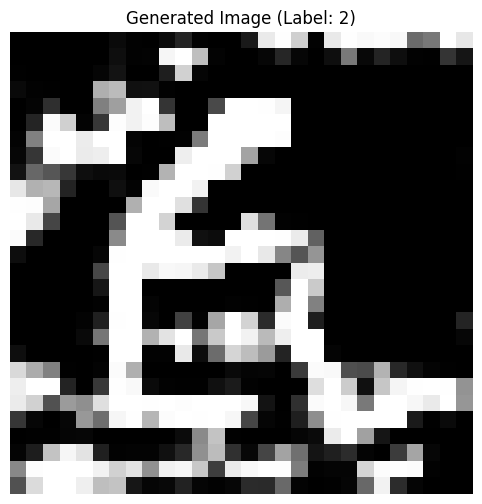

✓ Images saved: generated_images_epoch_190.png and comparison_epoch_190.png



Generating images for epoch 195...


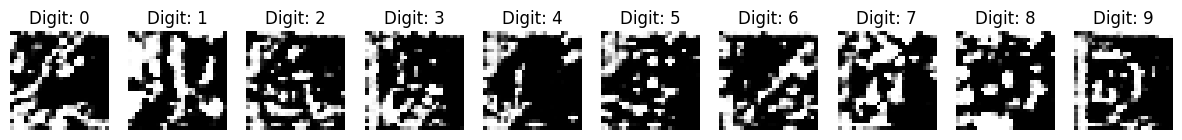

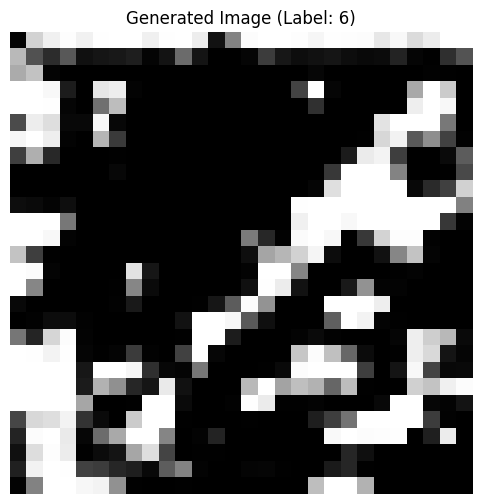

✓ Images saved: generated_images_epoch_195.png and comparison_epoch_195.png



Generating images for epoch 200...


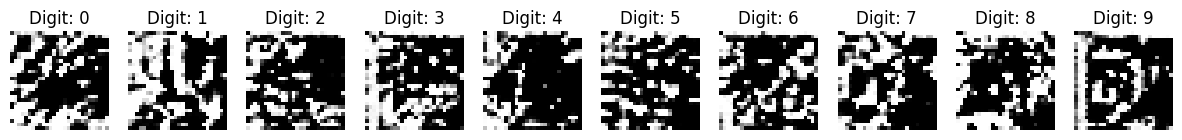

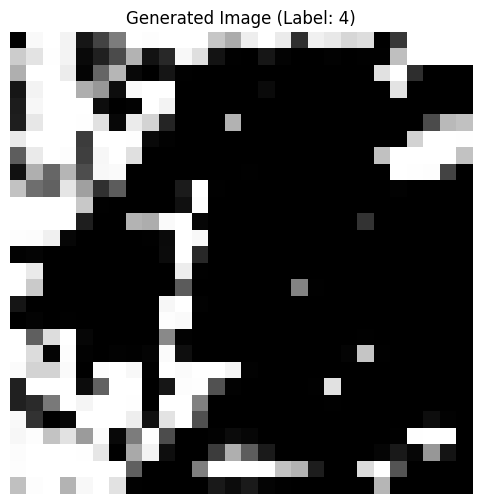

✓ Images saved: generated_images_epoch_200.png and comparison_epoch_200.png


In [ ]:
for epoch in range(EPOCH):
    gen.train() # 생성자 학습모드로 설정
    disc.train() # 판별자 학습모드로 설정
    for img, target in tqdm(train_loader, leave=False, total=len(train_loader)):# tqdm 반복문 진행 상황 플로그래스바로 표시
        img = img.cuda() # 이미지 gpu로 옮김 (gpu 학습 가능하도록 만듦)
        target = target.cuda() # target 도 gpu로 옮김
        n = len(img)

        # 판별자 학습
        noise = torch.randn(n, LATENT_DIM).cuda() # 랜덤한 잠재 벡터 생성 = 노이즈
        fake_data = gen(noise, target).detach() # 노이즈로 generator가 가짜 이미지 생성
        disc_loss = train_discriminator(criterion, d_optim, img, target, fake_data, target)
        # fake_data로 판별자가 학습해서 손실값 계산해서 1과 가까우면 진짜일 확률이 높다고 판단함.

        # 생성자 학습
        noise = torch.randn(n, LATENT_DIM).cuda()
        fake_data = gen(noise, target)
        gen_loss = train_generator(criterion, g_optim, fake_data, target)
        # 생성자는 손실값을 계산해서 손실값이 1과 가깝게 계속 학습함.

    if (epoch + 1) % 5 == 0: # 매 5에포크마다 실행하여 이미지 생성된거 확인함.
        print(f'\nGenerating images for epoch {epoch+1}...')
        gen.eval() # 생성자 평가모드로 전환
        with torch.no_grad():# d이미지 시각화용이라 학습할 필요 없다.
            # 각 숫자에 대한 이미지 생성
            test_noise = torch.randn(NUM_CLASSES, LATENT_DIM).cuda()
            # torch.randn() : 무작위 텐서 생성.가짜 이미지 생성할때 사용.
            # 10행인 이유는 0~9 대응되는 이미지 하나씩 만들려고.
            test_labels = torch.arange(0, NUM_CLASSES).cuda() # 0~9까지 생성함.
            test_images = gen(test_noise, test_labels) # noise+label 가짜 이미지 10개 생성

            # 생성된 이미지 시각화
            plt.figure(figsize=(15, 3))
            for j in range(NUM_CLASSES):
                plt.subplot(1, NUM_CLASSES, j + 1) # 이미지 여러개를 하나의 figure에 그려주는것. 0~9 생성된 이미지 나열
                img = test_images[j].cpu().squeeze().numpy()# numpy배열로 바꿔서 시각화
                img = (img + 1) / 2.0  # 정규화
                plt.imshow(img, cmap='gray')
                plt.title(f'Digit: {j}')
                plt.axis('off')

            plt.savefig(f'generated_images_epoch_{epoch+1}.png', bbox_inches='tight', pad_inches=0.1)
            plt.show()
            plt.close() # 다음 이미지 그릴때 충돌이나 메모리 낭비 방지하기 위해 메모리 닫기.

            plt.figure(figsize=(15, 6))
            fake_img = test_images[target[0].item()]  # index로 접근
            fake_img = (fake_img.detach().cpu().squeeze().numpy() + 1) / 2.0
            plt.imshow(fake_img, cmap='gray')
            plt.title(f'Generated Image (Label: {target[0].item()})')
            plt.axis('off')

            plt.savefig(f'comparison_epoch_{epoch+1}.png', bbox_inches='tight', pad_inches=0.1)
            plt.show()
            plt.close()

        gen.train()
        print(f'✓ Images saved: generated_images_epoch_{epoch+1}.png and comparison_epoch_{epoch+1}.png')



